# Тестирование симулятора затоплений на идеальном рельефе

**Цель работы:**
- Протестировать модуль для симуляции гидродинамического затопления с новыми возможностями
- Освоить среду для интерактивной обработки и визуализации данных (в которой составляется данный отчет)
- Подготовить основные переиспользуемые модули на Python для эффективного взаимодействия с .grd-картами и программой-симулятором в дальнейшем

In [17]:
%load_ext autoreload
%autoreload 2
import grd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Сгенерируем рельеф, представляющий из себя абсолютно ровную поверхность с главным руслом (шириной 3 ячейки) и сетью из дочерних русел (с шириной русла в 1 ячейку). Глубина всех русел: -$10м$, размер ячейки $50*50$ метров. Визуализируем результат.

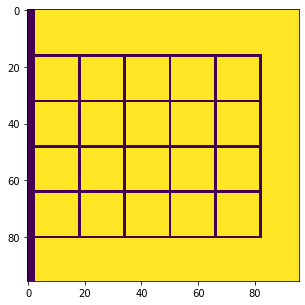

In [18]:
SIZE = 96
MAIN_CHAN_W = 3
STRUCT_STEP = 16
DEPTH = -10

relief = grd.create_map(SIZE, SIZE, 50, 0)

# Vertical
for x in range(SIZE):
    for y in range(MAIN_CHAN_W):
        relief.vals[x, y] = DEPTH
      
# Horizontal
for x in range(STRUCT_STEP, SIZE, STRUCT_STEP):
    for y in range(MAIN_CHAN_W, SIZE - STRUCT_STEP + MAIN_CHAN_W):
        relief.vals[x, y] = DEPTH
        
for y in range(MAIN_CHAN_W - 1, SIZE, STRUCT_STEP):
    for x in range(STRUCT_STEP, SIZE - STRUCT_STEP):
        relief.vals[x, y] = DEPTH

plt.gcf().set_size_inches(5, 5)
plt.imshow(relief.vals, aspect='equal')
plt.show()

Опишем исходные данные эксперимента. Установим дамбу в верхнюю часть основного русла, зададим расход воды $10 м^3/с$. В качестве шага сохранения результата возьмем временной промежуток в 1 час. Всего зададим 24 итерации, т.е. в целом просимулируем сутки затопления.

In [19]:
import simulation as sim

In [20]:
source = sim.Source(c1=(0, 0), c2=(MAIN_CHAN_W - 1, 1), rotate=0, qs=[10_000, 10_000])
exp0 = sim.Experiment(relief, 3600, 2, [source])

Запустим заданный эксперимент на симуляторе и засечем время его выполнения.

In [21]:
%%time
result = sim.run(exp0, 'data/exp0')

Wall time: 18 ms


Выведем максимальный уровень воды на последний день.

In [22]:
print(np.max(result.h[:-1]))

6.253742


Визуализируем карты затопления по первым 12 часам.

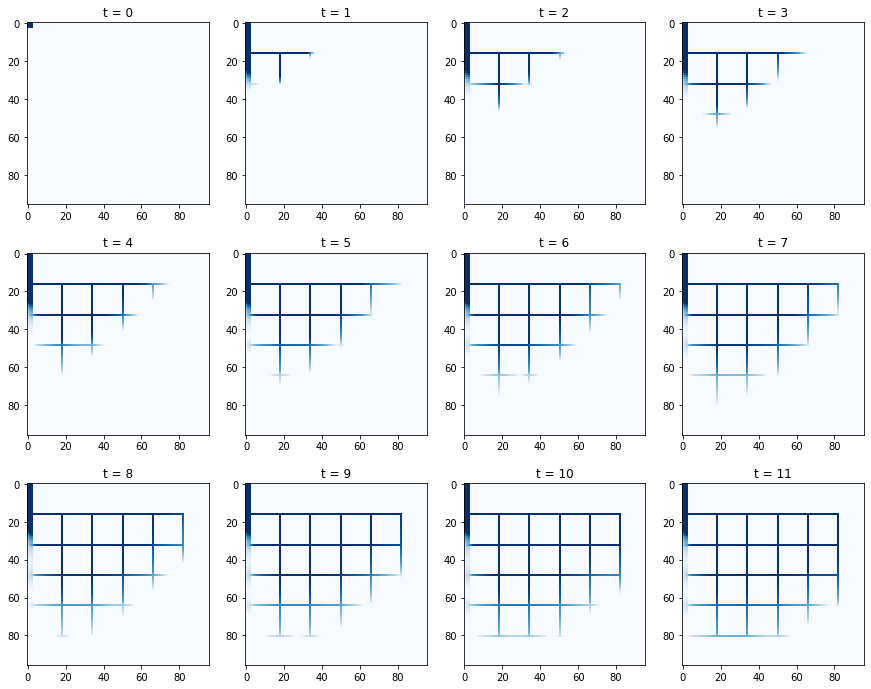

In [23]:
import visualisation as vis

vis.draw_water_distribution(result, 12)

Построим графики зависимости $V(t), S(t)$ - суммарный объем и площадь воды от часа затопления

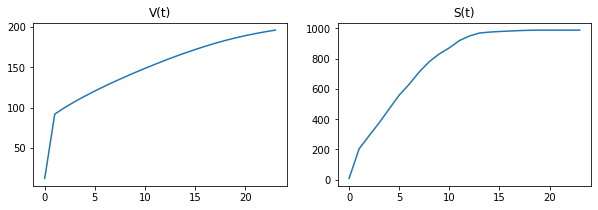

In [24]:
def draw_sv_graphs(result):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    vs = list(map(np.sum, result.h))
    ind_func = np.vectorize(lambda x: 1 if x > 0 else 0)
    h_inds = list(map(lambda h: np.sum(ind_func(h)), result.h))
    ss = list(map(np.sum, h_inds))
    axes[0].set_title('V(t)')
    axes[0].plot(vs)

    axes[1].set_title('S(t)')
    axes[1].plot(ss)

    plt.show()
    
draw_sv_graphs(result)

Рассмотрим зависимости $Q(t)$ на сечениях некоторых русел. Визуализируем слева сечение на карте, справа - соответствующий ему график расхода воды, прошедшей в каждый час. 

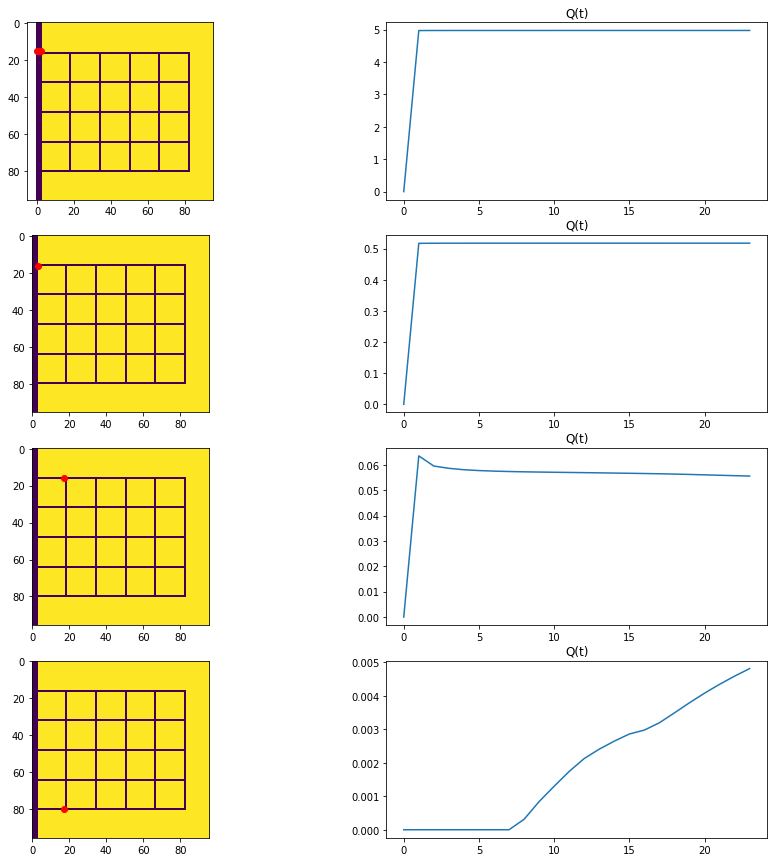

In [25]:
cuts = [
    [(STRUCT_STEP - 1, i) for i in range(MAIN_CHAN_W)],
    [(STRUCT_STEP, MAIN_CHAN_W)],
    [(STRUCT_STEP, MAIN_CHAN_W + STRUCT_STEP - 2)],
    [(SIZE - STRUCT_STEP, MAIN_CHAN_W + STRUCT_STEP - 2)]
]

def draw_cuts(result, relief, cuts):
    fig, axes = plt.subplots(len(cuts), 2, figsize=(15, 15))

    for i, cut in enumerate(cuts):
        axes[i, 0].imshow(relief.vals)
        x, y = list(zip(*list(map(reversed, cut))))
        axes[i, 0].scatter(x, y, c='red')
        axes[i, 1].plot(list(map(lambda it: sim.q_at(result, cut, it), range(24))))
        axes[i, 1].set_title('Q(t)')
    plt.show()

draw_cuts(result, relief, cuts)

Сгенерируем новый рельеф. Такой же по топологии, но с наклоном (уменьшением высоты на 0.1 с каждой новой ячейкой по направлению течения в основном русле). На визуализации этот наклон заметен в виде цветового градиента от голубого к синему.

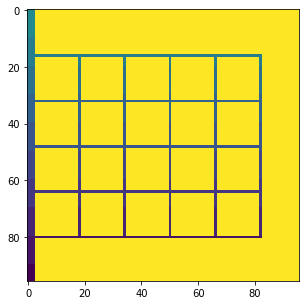

In [26]:
SLOPE = -0.1

relief2 = grd.create_map(SIZE, SIZE, 50, 0)

# Vertical
for x in range(SIZE):
    for y in range(MAIN_CHAN_W):
        relief2.vals[x, y] = DEPTH + x * SLOPE
      
# Horizontal
for x in range(STRUCT_STEP, SIZE, STRUCT_STEP):
    for y in range(MAIN_CHAN_W, SIZE - STRUCT_STEP + MAIN_CHAN_W):
        relief2.vals[x, y] = DEPTH + x * SLOPE
        
for y in range(MAIN_CHAN_W - 1, SIZE, STRUCT_STEP):
    for x in range(STRUCT_STEP, SIZE - STRUCT_STEP):
        relief2.vals[x, y] = DEPTH + x * SLOPE

plt.gcf().set_size_inches(5, 5)
plt.imshow(relief2.vals, aspect='equal')
plt.show()

In [27]:
import dataclasses
exp1 = dataclasses.replace(exp0, relief=relief2)

Запустим новый эксперимент и подготовим те же самые графики. 

In [28]:
%%time
result2 = sim.run(exp1, 'data/exp1')

Wall time: 40.9 s


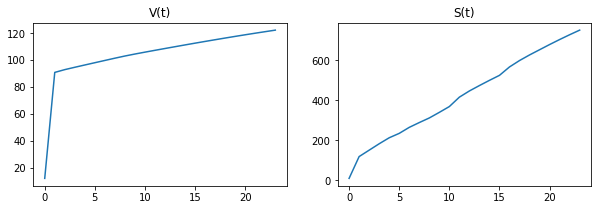

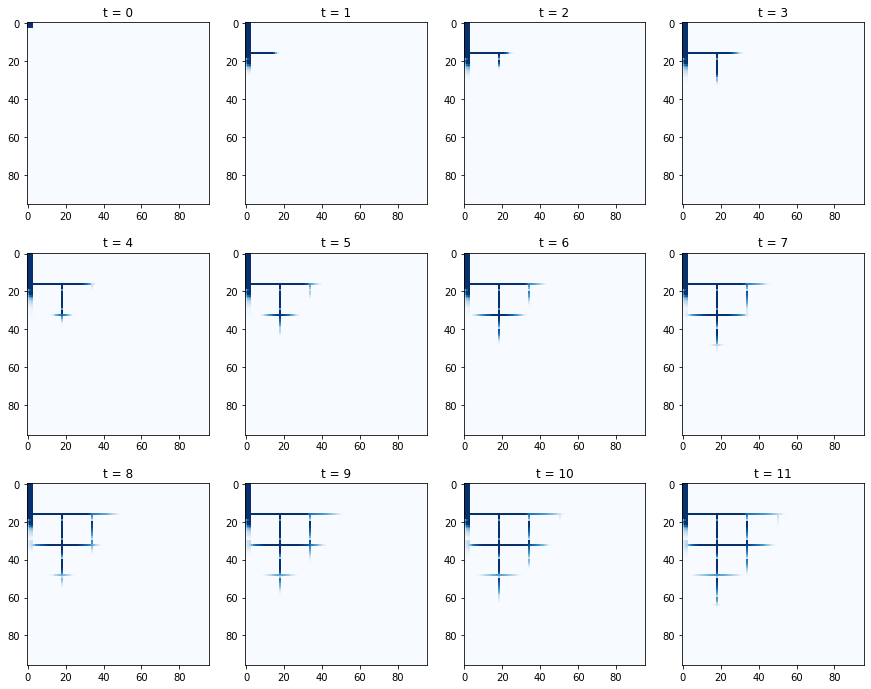

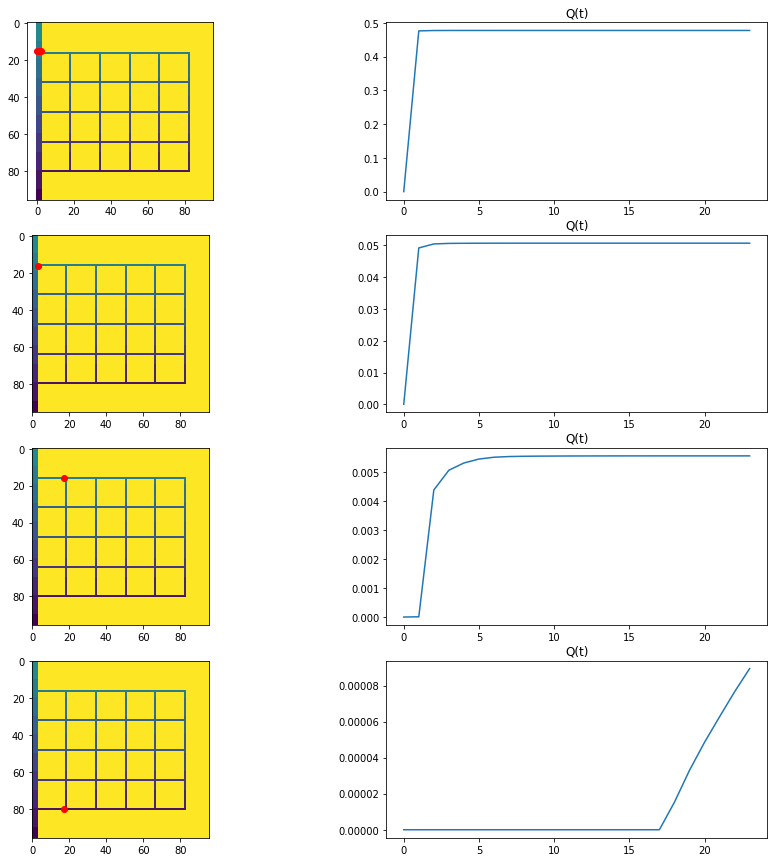

In [30]:
draw_sv_graphs(result2)
vis.draw_water_distribution(result2, 12)
draw_cuts(result2, relief2, cuts)